In [1]:
import sys, os, platform
from pathlib import Path

print("Python executable:", sys.executable)
print("Python version:", sys.version)
print("OS:", platform.platform())
print("Working directory:", os.getcwd())

PROJECT_ROOT = Path(
    r"C:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease"
)

SEQ_DIR = PROJECT_ROOT / "data" / "processed" / "per_file_seqs"
META_FILE = PROJECT_ROOT / "data" / "PaHaW_dataset" / "PaHaW_files" / "corpus_PaHaW.xlsx"

print("PROJECT_ROOT exists:", PROJECT_ROOT.exists())
print("SEQ_DIR exists:", SEQ_DIR.exists())
print("META_FILE exists:", META_FILE.exists())





Python executable: c:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease\.venv\Scripts\python.exe
Python version: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26100-SP0
Working directory: c:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease\notebooks
PROJECT_ROOT exists: True
SEQ_DIR exists: True
META_FILE exists: True


In [2]:
import pandas as pd

meta = pd.read_excel(META_FILE)
meta['ID'] = meta['ID'].astype(str).str.zfill(5)

label_map = {
    "PD": 1,
    "H": 0,
    "HC": 0,
    "Healthy": 0
}

meta['label'] = meta['Disease'].map(label_map)

print("Metadata loaded")
print("Total subjects:", len(meta))
print(meta[['ID', 'Disease', 'label']].head())
print(meta['Disease'].value_counts())


Metadata loaded
Total subjects: 75
      ID Disease  label
0  00001      PD      1
1  00002      PD      1
2  00003      PD      1
3  00004      PD      1
4  00005      PD      1
Disease
H     38
PD    37
Name: count, dtype: int64


In [3]:

import numpy as np
from pathlib import Path

SEQ_DIR = PROJECT_ROOT / "data" / "processed" / "per_file_seqs"
npz_files = sorted(SEQ_DIR.glob("*.npz"))

print("Total sequence files found:", len(npz_files))

X = []          
y = []         
meta_info = []

CAP = 300
FEAT_DIM = 14
skipped = 0

for f in npz_files:
    data = np.load(f)
    seq = data["X"]  

    if seq.ndim != 2 or seq.shape[1] != FEAT_DIM:
        skipped += 1
        continue

    if seq.shape[0] > CAP:
        seq = seq[:CAP]
    else:
        pad = CAP - seq.shape[0]
        seq = np.vstack([seq, np.zeros((pad, FEAT_DIM))])

    subject_id = f.stem.split("__")[0]

    row = meta[meta["ID"] == subject_id]
    if row.empty:
        skipped += 1
        continue

    label = int(row["label"].iloc[0])

    X.append(seq)
    y.append(label)
    meta_info.append(subject_id)

print("✅ Loaded sequences:", len(X))
print("❌ Skipped files:", skipped)
print("Example sequence shape:", X[0].shape if len(X) else None)
print("Label distribution:", {0: y.count(0), 1: y.count(1)})


Total sequence files found: 597
✅ Loaded sequences: 597
❌ Skipped files: 0
Example sequence shape: (300, 14)
Label distribution: {0: 302, 1: 295}


In [4]:

import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(X, dtype=np.float32)   
y = np.array(y, dtype=np.int32)

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("✅ Train samples:", X_train.shape[0])
print("✅ Validation samples:", X_val.shape[0])

print("Train label distribution:", {0: int((y_train==0).sum()), 1: int((y_train==1).sum())})
print("Val label distribution:", {0: int((y_val==0).sum()), 1: int((y_val==1).sum())})



X shape: (597, 300, 14)
y shape: (597,)
✅ Train samples: 477
✅ Validation samples: 120
Train label distribution: {0: 241, 1: 236}
Val label distribution: {0: 61, 1: 59}


In [5]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Bidirectional, LSTM
)
from tensorflow.keras.optimizers import Adam

print("TensorFlow version:", tf.__version__)

# -----------------------------
# Model definition
# -----------------------------
model = Sequential([
    Bidirectional(
        LSTM(
            units=64,
            return_sequences=True,
            activation="tanh"
        ),
        input_shape=(300, 14)
    ),
    Dropout(0.3),

    Bidirectional(
        LSTM(
            units=32,
            return_sequences=False,
            activation="tanh"
        )
    ),
    Dropout(0.3),

    Dense(32, activation="relu"),
    Dropout(0.2),

    Dense(1, activation="sigmoid")  
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


TensorFlow version: 2.12.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 300, 128)         40448     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         

In [6]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train
)

class_weight_dict = {
    0: class_weights[0],   # Healthy
    1: class_weights[1]    # Parkinson's
}

print("Class weights:", class_weight_dict)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,  
    verbose=1
)

print("✅ Training completed")


Class weights: {0: 0.9896265560165975, 1: 1.0105932203389831}
Epoch 1/100
30/30 [==============================] - 9s 151ms/step - loss: 0.7002 - accuracy: 0.4864 - val_loss: 0.6907 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 3s 115ms/step - loss: 0.6887 - accuracy: 0.5430 - val_loss: 0.6836 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - 3s 116ms/step - loss: 0.6809 - accuracy: 0.5618 - val_loss: 0.6757 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 4/100
30/30 [==============================] - 3s 116ms/step - loss: 0.6813 - accuracy: 0.5597 - val_loss: 0.6665 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 5/100
30/30 [==============================] - 3s 113ms/step - loss: 0.6760 - accuracy: 0.5891 - val_loss: 0.6714 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 6/100
30/30 [==============================] - 3s 109ms/step - loss: 0.6790 - accuracy: 0.5702 - val_loss: 0.6621 - val_accuracy: 0.5917 - lr: 0.0010
Ep

4/4 [==============================] - 1s 41ms/step
Validation Accuracy: 0.6833
ROC-AUC: 0.7052

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.69      0.69      0.69        61
          PD       0.68      0.68      0.68        59

    accuracy                           0.68       120
   macro avg       0.68      0.68      0.68       120
weighted avg       0.68      0.68      0.68       120



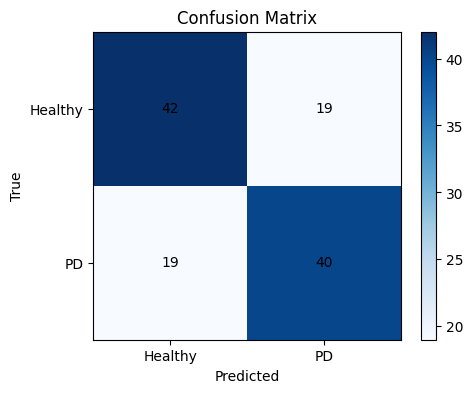

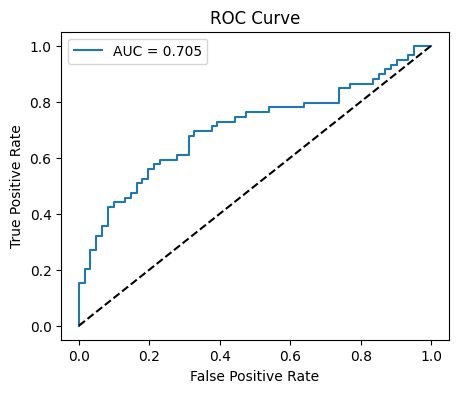

In [7]:

#EVALUATION & CONFUSION MATRIX

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

y_val_prob = model.predict(X_val).ravel()
y_val_pred = (y_val_prob >= 0.5).astype(int)

# Metrics

acc = accuracy_score(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_prob)

print("Validation Accuracy:", round(acc, 4))
print("ROC-AUC:", round(auc, 4))

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Healthy", "PD"]))

# Confusion Matrix (matplotlib)
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks([0,1], ["Healthy", "PD"])
plt.yticks([0,1], ["Healthy", "PD"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_prob)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [8]:


MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)

model_path = MODEL_DIR / "blstm_pahaw_model.h5"
model.save(model_path)

print("✅ Model saved at:", model_path)

✅ Model saved at: C:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease\models\blstm_pahaw_model.h5


In [9]:

import json

results = {
    "validation_accuracy": float(acc),
    "roc_auc": float(auc),
    "class_distribution": {
        "healthy": int((y_val == 0).sum()),
        "pd": int((y_val == 1).sum())
    }
}

out_path = PROJECT_ROOT / "results_metrics.json"
with open(out_path, "w") as f:
    json.dump(results, f, indent=4)

print("✅ Metrics saved to:", out_path)

✅ Metrics saved to: C:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease\results_metrics.json
